In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import datetime as dt
import dask.dataframe as dd

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches
from pathlib import Path
from sklearn.cluster import KMeans

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/bout")

In [3]:
from core import SITE_NAMES, FREQUENCY_COLOR_MAPPINGS
import clustering as clstr
import bout as bt
import plot as bt_plt
import activity.subsampling as ss
import activity.activity_assembly as actvt

from cli import get_file_paths
from calls import plot_call_features, compute_features, call_extraction

['/Users/adityakrishna/duty-cycle-investigation/daily_notebook', '/Users/adityakrishna/miniconda3/envs/dc-study/lib/python311.zip', '/Users/adityakrishna/miniconda3/envs/dc-study/lib/python3.11', '/Users/adityakrishna/miniconda3/envs/dc-study/lib/python3.11/lib-dynload', '', '/Users/adityakrishna/miniconda3/envs/dc-study/lib/python3.11/site-packages', '../src', '../src/bout', '../src/bout', '../src/bout', '../src/bout', '../src', '../src', '../src/activity', '/Users/adityakrishna/duty-cycle-investigation/daily_notebook/../src/calls', '/Users/adityakrishna/duty-cycle-investigation/daily_notebook/../src', '/Users/adityakrishna/duty-cycle-investigation/daily_notebook/../src/bout', '/Users/adityakrishna/duty-cycle-investigation/daily_notebook/../src']


In [4]:
FREQUENCY_COLOR_MAPPINGS = {
                    'LF' : 'cyan',
                    'HF' : 'orange'
                        }

LABEL_FOR_GROUPS = {
                    0: 'LF', 
                    1: 'HF'
                    }

FIGSIZE = (12, 6)

DURATION = 300

In [5]:
PADDED_CALL_LENGTH = 0.06

def open_and_get_call_info(audio_file, dets):
    welch_key = 'all_locations'
    output_dir = Path(f'../data/generated_welch/{welch_key}')
    output_file_type = 'top1_inbouts_welch_signals'
    welch_data = pd.read_csv(output_dir / f'2022_{welch_key}_{output_file_type}.csv', index_col=0, low_memory=False)
    k = 2
    kmean_welch = KMeans(n_clusters=k, n_init=10, random_state=1).fit(welch_data.values)

    features_of_interest = gather_features_of_interest(dets, kmean_welch, audio_file)

    dets.reset_index(drop=True, inplace=True)
    dets['index'] = dets.index
    dets['file_name'] = pd.DatetimeIndex(pd.to_datetime(dets['input_file'], format='%Y%m%d_%H%M%S', exact=False)).strftime('%Y%m%d_%H%M%S.WAV')
    dets['sampling_rate'] = len(dets) * [audio_file.samplerate]
    dets.insert(0, 'SNR', features_of_interest['snrs'])
    dets.insert(0, 'peak_frequency', features_of_interest['peak_freqs'])
    dets.insert(0, 'KMEANS_CLASSES', pd.Series(features_of_interest['classes']).map(LABEL_FOR_GROUPS))

    return features_of_interest['call_signals'], dets

def gather_features_of_interest(dets, kmean_welch, audio_file):
    fs = audio_file.samplerate
    features_of_interest = dict()
    features_of_interest['call_signals'] = []
    features_of_interest['welch_signals'] = []
    features_of_interest['snrs'] = []
    features_of_interest['peak_freqs'] = []
    features_of_interest['classes'] = []
    nyquist = fs//2
    for index, row in dets.iterrows():
        audio_seg, length_of_section = get_section_of_call_in_file(row, audio_file)
        
        freq_pad = 2000
        low_freq_cutoff = row['low_freq']-freq_pad
        high_freq_cutoff = min(nyquist-1, row['high_freq']+freq_pad)
        band_limited_audio_seg = call_extraction.bandpass_audio_signal(audio_seg, fs, low_freq_cutoff, high_freq_cutoff)

        signal = band_limited_audio_seg.copy()
        signal[:int(fs*(length_of_section))] = 0
        noise = band_limited_audio_seg - signal
        snr_call_signal = signal[-int(fs*length_of_section):]
        snr_noise_signal = noise[:int(fs*length_of_section)]
        features_of_interest['call_signals'].append(snr_call_signal)

        snr = call_extraction.get_snr_from_band_limited_signal(snr_call_signal, snr_noise_signal)
        features_of_interest['snrs'].append(snr)

        welch_info = dict()
        welch_info['num_points'] = 100
        max_visible_frequency = 96000
        welch_info['max_freq_visible'] = max_visible_frequency
        welch_signal = compute_features.compute_welch_psd_of_call(snr_call_signal, fs, welch_info)
        features_of_interest['welch_signals'].append(welch_signal)

        peaks = np.where(welch_signal==max(welch_signal))[0][0]
        features_of_interest['peak_freqs'].append((max_visible_frequency/len(welch_signal))*peaks)
        
        welch_signal = (welch_signal).reshape(1, len(welch_signal))
        features_of_interest['classes'].append(kmean_welch.predict(welch_signal)[0])

    features_of_interest['call_signals'] = np.array(features_of_interest['call_signals'], dtype='object')

    return features_of_interest

def get_section_of_call_in_file(detection, audio_file):
    fs = audio_file.samplerate
    call_dur = (detection['end_time'] - detection['start_time'])
    pad = 0.004
    start = detection['start_time'] - call_dur - (3*pad)
    duration = (2 * call_dur) + (4*pad)
    end = detection['end_time']
    audio_file.seek(int(fs*start))
    audio_seg = audio_file.read(int(fs*duration))

    length_of_section = call_dur + (2*pad)

    return audio_seg, length_of_section

In [6]:
def plot_colored_dets_over_audio_seg(audio_features, spec_features, plot_dets):
    """
    Function to plot the spectrogram of a provided audio segment with overlayed detections
    """

    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    plt.figure(figsize=FIGSIZE)
    plt.rcParams.update({'font.size': 24})
    plt.title(f"BatDetect2 detections on {audio_features['file_path'].name}", fontsize=22)
    plt.specgram(audio_seg, NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmin=spec_features['vmin'])

    yellow_patch = patches.Patch(facecolor='yellow', edgecolor='k', label='Detections')

    legend_patches = [yellow_patch]
    ax = plt.gca()
    for i, row in plot_dets.iterrows():
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=2, edgecolor=FREQUENCY_COLOR_MAPPINGS[row['KMEANS_CLASSES']], facecolor='none', alpha=1)
        
        ax.add_patch(rect)

    plt.yticks(ticks=np.linspace(0, 96000/(fs/2), 11), labels=np.linspace(0, 96, 11).astype('int'))
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.ylim(0, 96000/(fs/2))
    plt.xlabel("Time (s)")
    plt.gcf().autofmt_xdate()
    plt.grid(axis='y')
    plt.legend(handles=legend_patches, fontsize=20, ncol=int(len(legend_patches)**0.5), loc='upper right')

    plt.tight_layout()
    plt.show()

def plot_audio_seg(audio_features, spec_features):
    """
    Function to plot the spectrogram of a provided audio segment
    """

    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    plt.figure(figsize=FIGSIZE)
    plt.rcParams.update({'font.size' : 24})
    plt.title(f"Audio collected from {audio_features['site_name']} on {audio_features['file_datetime']} UTC", fontsize=22)
    plt.rcParams.update({'font.size': 24})
    plt.specgram(audio_seg, NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmin=spec_features['vmin'])
    plt.yticks(ticks=np.linspace(0, 96000/(fs/2), 11), labels=np.linspace(0, 96, 11).astype('int'))
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.ylim(0, 96000/(fs/2))
    plt.xlabel("Time (s)")
    plt.gcf().autofmt_xdate()
    plt.grid(axis='y')

    plt.tight_layout()
    plt.show()

def load_and_plot_file(file_path, csv_path, start, duration, rm_dB=50, nfft=1024):
    audio_file = sf.SoundFile(file_path)
    fs = audio_file.samplerate
    audio_file.seek(int(fs*start))
    audio_seg = audio_file.read(int(fs*duration))
    vmin = 20*np.log10(np.max(audio_seg)) -  rm_dB # hide anything below -rm_dB dB

    audio_features = dict()
    audio_features['site_name'] = SITE_NAMES[file_path.parent.name]
    audio_features['file_datetime'] = dt.datetime.strptime(file_path.name, "%Y%m%d_%H%M%S.WAV").strftime('%Y/%m/%d %H:%M')
    audio_features['file_path'] = file_path
    audio_features['audio_seg'] = audio_seg
    audio_features['sample_rate'] = fs
    audio_features['start'] = start
    audio_features['duration'] = duration

    spec_features = dict()
    spec_features['vmin'] = vmin
    spec_features['NFFT'] = nfft
    spec_features['cmap'] = 'jet'

    site_key = file_path.parent.name

    data_params = dict()
    data_params['site_tag'] = site_key
    data_params['type_tag'] = ''
    data_params['cur_dc_tag'] = '1800of1800'
    batdetect2_predictions_no_dutycycle = actvt.assemble_single_bd2_output(csv_path, data_params)
    plot_dets_no_dutycycle = batdetect2_predictions_no_dutycycle.loc[np.logical_and(batdetect2_predictions_no_dutycycle['start_time'] > start, batdetect2_predictions_no_dutycycle['end_time'] < (start+duration))]

    plot_audio_seg(audio_features, spec_features)
    call_signals, dets = open_and_get_call_info(audio_file, plot_dets_no_dutycycle.copy())
    plot_colored_dets_over_audio_seg(audio_features, spec_features, dets)

Looking at Foliage
Looking at 20210910_030000.WAV


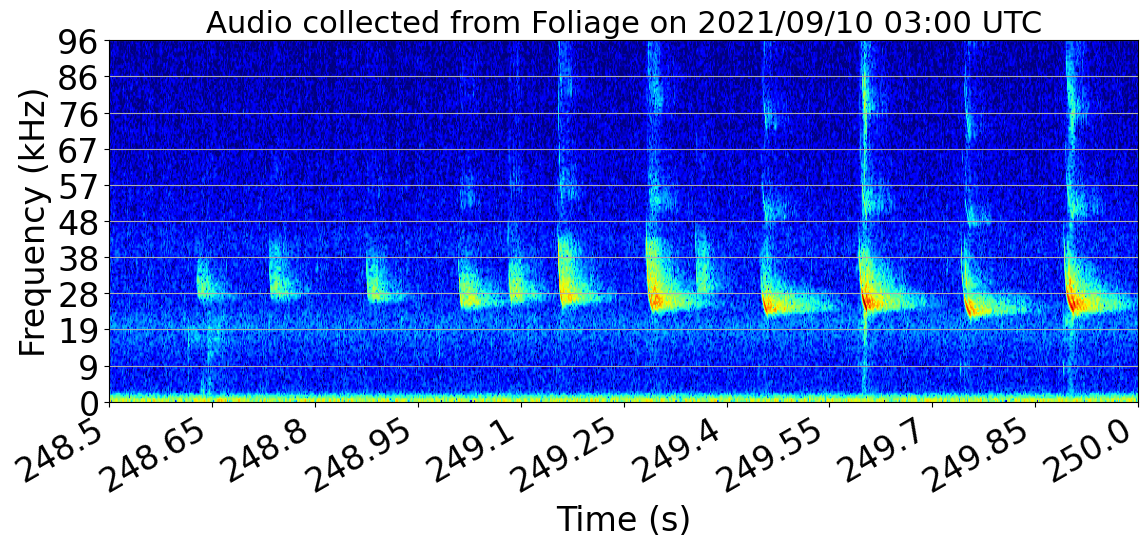

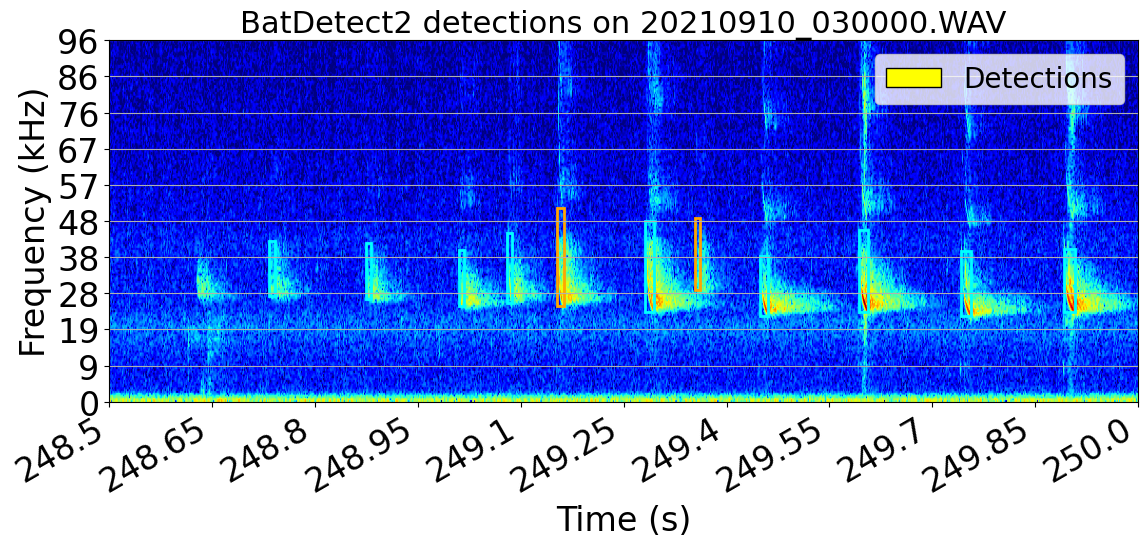

In [7]:
site_key = 'Foliage'

fig_details = dict()
fig_details['site_name'] = SITE_NAMES[site_key]
print(f'Looking at {fig_details["site_name"]}')
files_from_loc = sorted(list(Path(f'../data/audiomoth_recordings/').glob(pattern=f'*/{site_key}/*.WAV')))

file_path = files_from_loc[0]
filename = file_path.name
csv_path = Path(f'../batdetect2_outputs/recover-20210912/{site_key}/bd2_{filename.split(".")[0]}.csv')
print(f'Looking at {file_path.name}')
start = 248.5
duration = 1.5
rm_dB = 60
nfft = 512

load_and_plot_file(file_path, csv_path, start, duration, rm_dB, nfft)

In [8]:
site_key = file_path.parent.name

data_params = dict()
data_params['site_tag'] = site_key
data_params['type_tag'] = ''
data_params['cur_dc_tag'] = '1800of1800'
batdetect2_predictions_no_dutycycle = actvt.assemble_single_bd2_output(csv_path, data_params)
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
call_signals, dets = open_and_get_call_info(audio_file, batdetect2_predictions_no_dutycycle.copy())
dets

KMEANS_CLASSES  peak_frequency        SNR freq_group  \
0                LF         31680.0   9.630549        LF1   
1                LF         28800.0  16.757101        LF1   
2                LF         28800.0  13.010155        LF1   
3                LF         28800.0  17.581284        LF1   
4                LF         29760.0  17.719339        LF1   
...             ...             ...        ...        ...   
3206             LF         25920.0   3.447606        LF1   
3207             LF         27840.0   2.195712        LF1   
3208             LF         26880.0   6.772881        LF1   
3209             LF         26880.0   6.739896        LF1   
3210             LF         27840.0   3.277215        LF1   

                       ref_time            call_start_time  \
0    2021-09-10 03:04:06.932500 2021-09-10 03:04:06.932500   
1    2021-09-10 03:04:07.216500 2021-09-10 03:04:07.216500   
2    2021-09-10 03:04:07.352500 2021-09-10 03:04:07.352500   
3    2021-09-10 03:04:07.471500 2021-09-10 03:04:07.471500   
4    2021-09-10 03:04:07.590500 2021-09-10 03:04:07.590500   
...                         ...                        ...   
3206 2021-09-10 03:29:41.446500 2021-09-10 03:29:41.446500   
3207 2021-09-10 03:29:41.578500 2021-09-10 03:29:41.578500   
3208 2021-09-10 03:29:41.938500 2021-09-10 03:29:41.938500   
3209 2021-09-10 03:29:42.061500 2021-09-10 03:29:42.061500   
3210 2021-09-10 03:29:42.573500 2021-09-10 03:29:42.573500   

                  call_end_time  start_time   end_time  low_freq  ...  \
0    2021-09-10 03:04:06.941800    246.9325   246.9418   28046.0  ...   
1    2021-09-10 03:04:07.226400    247.2165   247.2264   28046.0  ...   
2    2021-09-10 03:04:07.362700    247.3525   247.3627   28046.0  ...   
3    2021-09-10 03:04:07.479400    247.4715   247.4794   27187.0  ...   
4    2021-09-10 03:04:07.600100    247.5905   247.6001   28046.0  ...   
...                         ...         ...        ...       ...  ...   
3206 2021-09-10 03:29:41.456500   1781.4465  1781.4565   25468.0  ...   
3207 2021-09-10 03:29:41.589100   1781.5785  1781.5891   26328.0  ...   
3208 2021-09-10 03:29:41.947700   1781.9385  1781.9477   26328.0  ...   
3209 2021-09-10 03:29:42.070200   1782.0615  1782.0702   25468.0  ...   
3210 2021-09-10 03:29:42.581900   1782.5735  1782.5819   26328.0  ...   

      class_prob det_prob individual  \
0          0.402    0.549         -1   
1          0.415    0.573         -1   
2          0.422    0.555         -1   
3          0.546    0.763         -1   
4          0.376    0.530         -1   
...          ...      ...        ...   
3206       0.273    0.584         -1   
3207       0.328    0.577         -1   
3208       0.294    0.614         -1   
3209       0.393    0.600         -1   
3210       0.310    0.511         -1   

                                             input_file  \
0     /Users/adityakrishna/Documents/Research/Lab_re...   
1     /Users/adityakrishna/Documents/Research/Lab_re...   
2     /Users/adityakrishna/Documents/Research/Lab_re...   
3     /Users/adityakrishna/Documents/Research/Lab_re...   
4     /Users/adityakrishna/Documents/Research/Lab_re...   
...                                                 ...   
3206  /Users/adityakrishna/Documents/Research/Lab_re...   
3207  /Users/adityakrishna/Documents/Research/Lab_re...   
3208  /Users/adityakrishna/Documents/Research/Lab_re...   
3209  /Users/adityakrishna/Documents/Research/Lab_re...   
3210  /Users/adityakrishna/Documents/Research/Lab_re...   

              Recover Folder   SD Card Site name index            file_name  \
0     recover-20210912_unit2  UBNA_002   Foliage     0  20210910_030000.WAV   
1     recover-20210912_unit2  UBNA_002   Foliage     1  20210910_030000.WAV   
2     recover-20210912_unit2  UBNA_002   Foliage     2  20210910_030000.WAV   
3     recover-20210912_unit2  UBNA_002   Foliage     3  20210910_030000.WAV   
4     recover-20210912_unit2  UBNA_002   Foliage     4  20210910_

In [9]:
plot_dets_no_dutycycle = dets.loc[np.logical_and(dets['start_time'] > start, dets['end_time'] < (start+duration))]
plot_dets_no_dutycycle

KMEANS_CLASSES  peak_frequency        SNR freq_group  \
7              LF         30720.0  19.177603        LF1   
8              LF         28800.0  19.621034        LF1   
9              LF         26880.0  23.798032        LF1   
10             LF         28800.0  14.746499        LF1   
11             HF         28800.0  31.416530              
12             LF         26880.0  35.648848        LF1   
13             HF         32640.0   8.195452        LF1   
14             LF         25920.0  36.921104        LF1   
15             LF         26880.0  44.668997        LF1   
16             LF         24960.0  36.334017        LF1   
17             LF         25920.0  45.104573        LF1   

                     ref_time            call_start_time  \
7  2021-09-10 03:04:08.733500 2021-09-10 03:04:08.733500   
8  2021-09-10 03:04:08.874500 2021-09-10 03:04:08.874500   
9  2021-09-10 03:04:09.009500 2021-09-10 03:04:09.009500   
10 2021-09-10 03:04:09.080500 2021-09-10 03:04:09.080500   
11 2021-09-10 03:04:09.153500 2021-09-10 03:04:09.153500   
12 2021-09-10 03:04:09.281500 2021-09-10 03:04:09.281500   
13 2021-09-10 03:04:09.354500 2021-09-10 03:04:09.354500   
14 2021-09-10 03:04:09.448500 2021-09-10 03:04:09.448500   
15 2021-09-10 03:04:09.592500 2021-09-10 03:04:09.592500   
16 2021-09-10 03:04:09.742500 2021-09-10 03:04:09.742500   
17 2021-09-10 03:04:09.892500 2021-09-10 03:04:09.892500   

                call_end_time  start_time  end_time  low_freq  ...  \
7  2021-09-10 03:04:08.741400    248.7335  248.7414   28046.0  ...   
8  2021-09-10 03:04:08.882000    248.8745  248.8820   27187.0  ...   
9  2021-09-10 03:04:09.017800    249.0095  249.0178   25468.0  ...   
10 2021-09-10 03:04:09.087800    249.0805  249.0878   26328.0  ...   
11 2021-09-10 03:04:09.162800    249.1535  249.1628   25468.0  ...   
12 2021-09-10 03:04:09.294300    249.2815  249.2943   23750.0  ...   
13 2021-09-10 03:04:09.362000    249.3545  249.3620   29765.0  ...   
14 2021-09-10 03:04:09.460800    249.4485  249.4608   22890.0  ...   
15 2021-09-10 03:04:09.605900    249.5925  249.6059   23750.0  ...   
16 2021-09-10 03:04:09.756800    249.7425  249.7568   22890.0  ...   
17 2021-09-10 03:04:09.907600    249.8925  249.9076   23750.0  ...   

    class_prob det_prob individual  \
7        0.533    0.614         -1   
8        0.576    0.652         -1   
9        0.612    0.704         -1   
10       0.515    0.632         -1   
11       0.623    0.754         -1   
12       0.598    0.747         -1   
13       0.458    0.535         -1   
14       0.467    0.675         -1   
15       0.644    0.753         -1   
16       0.407    0.680         -1   
17       0.429    0.587         -1   

                                           input_file          Recover Folder  \
7   /Users/adityakrishna/Documents/Research/Lab_re...  recover-20210912_unit2   
8   /Users/adityakrishna/Documents/Research/Lab_re...  recover-20210912_unit2   
9   /Users/adityakrishna/Documents/Research/Lab_re...  recover-20210912_unit2   
10  /Users/adityakrishna/Documents/Research/Lab_re...  recover-20210912_unit2   
11  /Users/adityakrishna/Documents/Research/Lab_re...  recover-20210912_unit2   
12  /Users/adityakrishna/Documents/Research/Lab_re...  recover-20210912_unit2   
13  /Users/adityakrishna/Documents/Research/Lab_re...  recover-20210912_unit2   
14  /Users/adityakrishna/Documents/Research/Lab_re...  recover-20210912_unit2   
15  /Users/adityakrishna/Documents/Research/Lab_re...  recover-20210912_unit2   
16  /Users/adityakrishna/Documents/Research/Lab_re...  recover-20210912_unit2   
17  /Users/adityakrishna/Documents/Research/Lab_re...  recover-20210912_unit2   

     SD Card Site name index            file_name sampling_rate  
7   UBNA_002   Foliage     7  20210910_030000.WAV        250000  
8   UBNA_002   Foliage     8  20210910_030000.WAV        250000  
9   UBNA_002   Foliage     9  20210910_030000.WAV        250000  
10  UBNA_002   Foliage    10  20210910

In [10]:
median_peak_HF_freq = dets[dets['KMEANS_CLASSES']=='HF']['peak_frequency'].median()
median_peak_LF_freq = dets[dets['KMEANS_CLASSES']=='LF']['peak_frequency'].median()
median_peak_HF_freq, median_peak_LF_freq

(42240.0, 25920.0)

In [11]:
inds = np.isclose(plot_dets_no_dutycycle['peak_frequency'], median_peak_LF_freq, rtol=0.26)
inds

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

Looking at Foliage
Looking at 20210910_030000.WAV


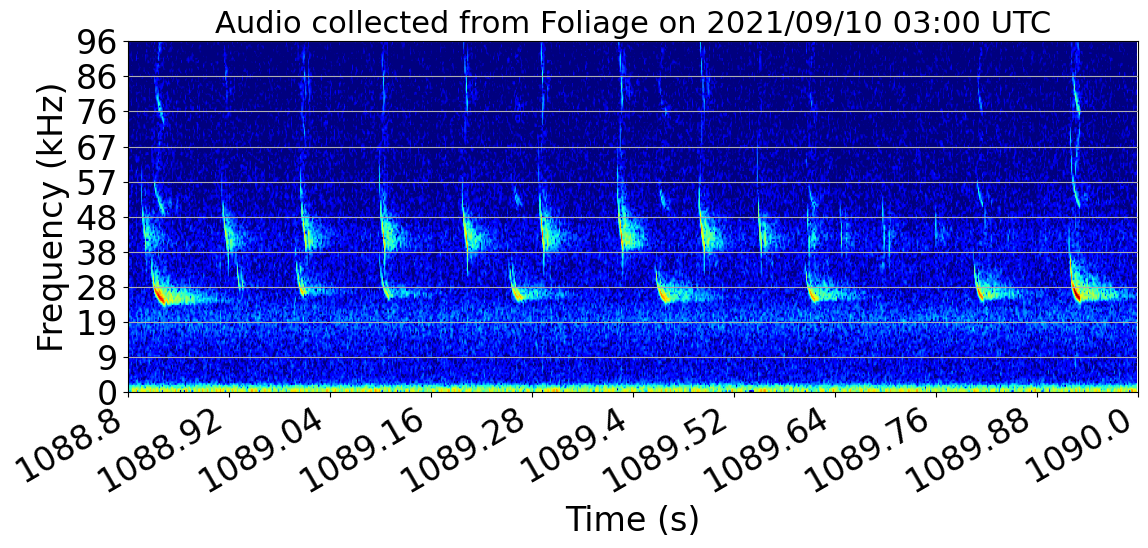

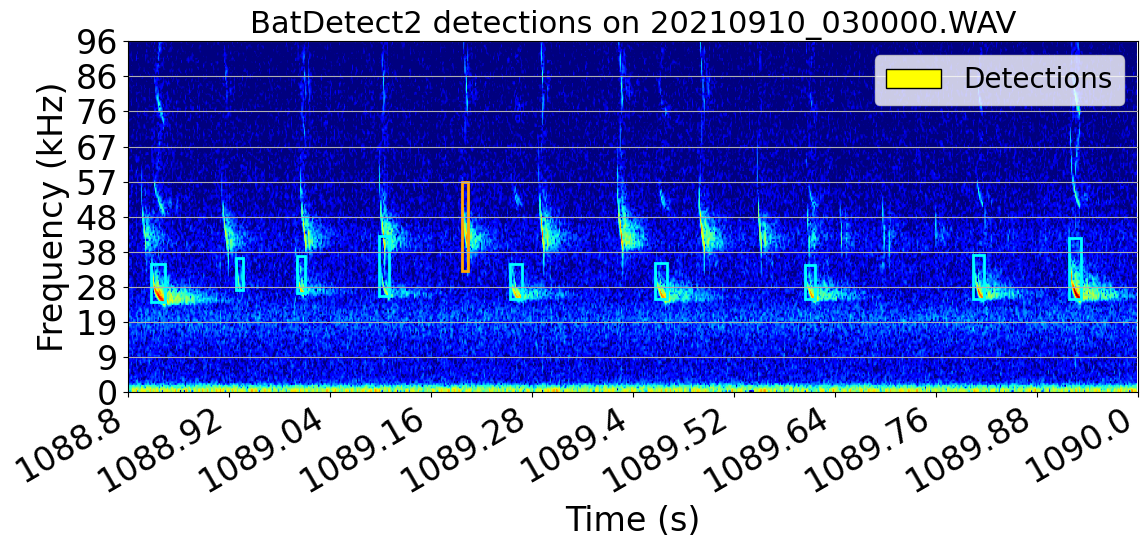

In [12]:
site_key = 'Foliage'

fig_details = dict()
fig_details['site_name'] = SITE_NAMES[site_key]
print(f'Looking at {fig_details["site_name"]}')
files_from_loc = sorted(list(Path(f'../data/audiomoth_recordings/').glob(pattern=f'*/{site_key}/*.WAV')))

file_path = files_from_loc[0]
filename = file_path.name
csv_path = Path(f'../batdetect2_outputs/recover-20210912/{site_key}/bd2_{filename.split(".")[0]}.csv')
print(f'Looking at {file_path.name}')
start = 1088.8
duration = 1.2
rm_dB = 50
nfft = 512

load_and_plot_file(file_path, csv_path, start, duration, rm_dB, nfft)

In [13]:
site_key = file_path.parent.name

data_params = dict()
data_params['site_tag'] = site_key
data_params['type_tag'] = ''
data_params['cur_dc_tag'] = '1800of1800'
batdetect2_predictions_no_dutycycle = actvt.assemble_single_bd2_output(csv_path, data_params)
plot_dets_no_dutycycle = batdetect2_predictions_no_dutycycle.loc[np.logical_and(batdetect2_predictions_no_dutycycle['start_time'] > start, batdetect2_predictions_no_dutycycle['end_time'] < (start+duration))]
plot_dets_no_dutycycle

freq_group                   ref_time            call_start_time  \
1241        LF1 2021-09-10 03:18:08.827500 2021-09-10 03:18:08.827500   
1242        LF1 2021-09-10 03:18:08.928500 2021-09-10 03:18:08.928500   
1243        LF1 2021-09-10 03:18:09.000500 2021-09-10 03:18:09.000500   
1244        LF1 2021-09-10 03:18:09.098500 2021-09-10 03:18:09.098500   
1245            2021-09-10 03:18:09.197500 2021-09-10 03:18:09.197500   
1246        LF1 2021-09-10 03:18:09.254500 2021-09-10 03:18:09.254500   
1247        LF1 2021-09-10 03:18:09.426500 2021-09-10 03:18:09.426500   
1248        LF1 2021-09-10 03:18:09.604500 2021-09-10 03:18:09.604500   
1249        LF1 2021-09-10 03:18:09.803500 2021-09-10 03:18:09.803500   
1250        LF1 2021-09-10 03:18:09.917500 2021-09-10 03:18:09.917500   

                     call_end_time  start_time   end_time  low_freq  \
1241 2021-09-10 03:18:08.844600000   1088.8275  1088.8446   24609.0   
1242 2021-09-10 03:18:08.937400000   1088.9285  1088.9374   28046.0   
1243 2021-09-10 03:18:09.010500000   1089.0005  1089.0105   27187.0   
1244 2021-09-10 03:18:09.109900000   1089.0985  1089.1099   26328.0   
1245 2021-09-10 03:18:09.203600000   1089.1975  1089.2036   33203.0   
1246 2021-09-10 03:18:09.268299999   1089.2545  1089.2683   25468.0   
1247 2021-09-10 03:18:09.440600000   1089.4265  1089.4406   25468.0   
1248 2021-09-10 03:18:09.616900000   1089.6045  1089.6169   25468.0   
1249 2021-09-10 03:18:09.817000000   1089.8035  1089.8170   25468.0   
1250 2021-09-10 03:18:09.932300000   1089.9175  1089.9323   25468.0   

      high_freq         event                class  class_prob  det_prob  \
1241    35028.0  Echolocation  Eptesicus serotinus       0.333     0.546   
1242    36585.0  Echolocation  Eptesicus serotinus       0.318     0.586   
1243    37231.0  Echolocation  Eptesicus serotinus       0.335     0.674   
1244    42688.0  Echolocation  Eptesicus serotinus       0.331     0.595   
1245    57599.0  Echolocation   Myotis daubentonii       0.327     0.542   
1246    34986.0  Echolocation  Eptesicus serotinus       0.329     0.652   
1247    35308.0  Echolocation  Eptesicus serotinus       0.383     0.636   
1248    34821.0  Echolocation  Eptesicus serotinus       0.303     0.649   
1249    37410.0  Echolocation  Eptesicus serotinus       0.461     0.675   
1250    42167.0  Echolocation  Eptesicus serotinus       0.319     0.669   

      individual                                         input_file  \
1241          -1  /Users/adityakrishna/Documents/Research/Lab_re...   
1242          -1  /Users/adityakrishna/Documents/Research/Lab_re...   
1243          -1  /Users/adityakrishna/Documents/Research/Lab_re...   
1244          -1  /Users/adityakrishna/Documents/Research/Lab_re...   
1245          -1  /Users/adityakrishna/Documents/Research/Lab_re...   
1246          -1  /Users/adityakrishna/Documents/Research/Lab_re...   
1247          -1  /Users/adityakrishna/Documents/Research/Lab_re...   
1248          -1  /Users/adityakrishna/Documents/Research/Lab_re...   
1249          -1  /Users/adityakrishna/Documents/Research/Lab_re...   
1250          -1  /Users/adityakrishna/Documents/Research/Lab_re...   

              Recover Folder   SD Card Site name  
1241  recover-20210912_unit2  UBNA_002   Foliage  
1242  recover-20210912_unit2  UBNA_002   Foliage  
1243  recover-20210912_unit2  UBNA_002   Foliage  
1244  recover-20210912_unit2  UBNA_002   Foliage  
1245  recover-20210912_unit2  UBNA_002   Foliage  
1246  recover-20210912_unit2  UBNA_002   Foliage  
1247  recover-20210912_unit2  UBNA_002   Foliage  
1248  recover-20210912_unit2  UBNA_002   Foliage  
1249  recover-20210912_unit2  UBNA_002   Foliage  
1250  recover-20210912_unit2  UBNA_002   Foliage

In [14]:
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
call_signals, dets = open_and_get_call_info(audio_file, plot_dets_no_dutycycle.copy())
dets

KMEANS_CLASSES  peak_frequency        SNR freq_group  \
0             LF         25920.0  34.484002        LF1   
1             LF         31680.0   5.149531        LF1   
2             LF         27840.0  26.332655        LF1   
3             LF         41280.0  23.965378        LF1   
4             HF         43200.0  29.914131              
5             LF         26880.0  26.313803        LF1   
6             LF         26880.0  28.385309        LF1   
7             LF         26880.0  27.699405        LF1   
8             LF         26880.0  29.607265        LF1   
9             LF         26880.0  39.207114        LF1   

                    ref_time            call_start_time  \
0 2021-09-10 03:18:08.827500 2021-09-10 03:18:08.827500   
1 2021-09-10 03:18:08.928500 2021-09-10 03:18:08.928500   
2 2021-09-10 03:18:09.000500 2021-09-10 03:18:09.000500   
3 2021-09-10 03:18:09.098500 2021-09-10 03:18:09.098500   
4 2021-09-10 03:18:09.197500 2021-09-10 03:18:09.197500   
5 2021-09-10 03:18:09.254500 2021-09-10 03:18:09.254500   
6 2021-09-10 03:18:09.426500 2021-09-10 03:18:09.426500   
7 2021-09-10 03:18:09.604500 2021-09-10 03:18:09.604500   
8 2021-09-10 03:18:09.803500 2021-09-10 03:18:09.803500   
9 2021-09-10 03:18:09.917500 2021-09-10 03:18:09.917500   

                  call_end_time  start_time   end_time  low_freq  ...  \
0 2021-09-10 03:18:08.844600000   1088.8275  1088.8446   24609.0  ...   
1 2021-09-10 03:18:08.937400000   1088.9285  1088.9374   28046.0  ...   
2 2021-09-10 03:18:09.010500000   1089.0005  1089.0105   27187.0  ...   
3 2021-09-10 03:18:09.109900000   1089.0985  1089.1099   26328.0  ...   
4 2021-09-10 03:18:09.203600000   1089.1975  1089.2036   33203.0  ...   
5 2021-09-10 03:18:09.268299999   1089.2545  1089.2683   25468.0  ...   
6 2021-09-10 03:18:09.440600000   1089.4265  1089.4406   25468.0  ...   
7 2021-09-10 03:18:09.616900000   1089.6045  1089.6169   25468.0  ...   
8 2021-09-10 03:18:09.817000000   1089.8035  1089.8170   25468.0  ...   
9 2021-09-10 03:18:09.932300000   1089.9175  1089.9323   25468.0  ...   

   class_prob det_prob individual  \
0       0.333    0.546         -1   
1       0.318    0.586         -1   
2       0.335    0.674         -1   
3       0.331    0.595         -1   
4       0.327    0.542         -1   
5       0.329    0.652         -1   
6       0.383    0.636         -1   
7       0.303    0.649         -1   
8       0.461    0.675         -1   
9       0.319    0.669         -1   

                                          input_file          Recover Folder  \
0  /Users/adityakrishna/Documents/Research/Lab_re...  recover-20210912_unit2   
1  /Users/adityakrishna/Documents/Research/Lab_re...  recover-20210912_unit2   
2  /Users/adityakrishna/Documents/Research/Lab_re...  recover-20210912_unit2   
3  /Users/adityakrishna/Documents/Research/Lab_re...  recover-20210912_unit2   
4  /Users/adityakrishna/Documents/Research/Lab_re...  recover-20210912_unit2   
5  /Users/adityakrishna/Documents/Research/Lab_re...  recover-20210912_unit2   
6  /Users/adityakrishna/Documents/Research/Lab_re...  recover-20210912_unit2   
7  /Users/adityakrishna/Documents/Research/Lab_re...  recover-20210912_unit2   
8  /Users/adityakrishna/Documents/Research/Lab_re...  recover-20210912_unit2   
9  /Users/adityakrishna/Documents/Research/Lab_re...  recover-20210912_unit2   

    SD Card Site name index            file_name sampling_rate  
0  UBNA_002   Foliage     0  20210910_030000.WAV        250000  
1  UBNA_002   Foliage     1  20210910_030000.WAV        250000  
2  UBNA_002   Foliage     2  20210910_030000.WAV        250000  
3  UBNA_002   Foliage     3  20210910_030000.WAV        250000  
4  UBNA_002   Foliage     4  20210910_030000.WAV        250000  
5  UBNA_002   Foliage     5  20210910_030000.WAV        250000  
6  UBNA_002   Foliage     6  20210910_030000.WAV        250000  
7  UBNA_002   Foliage     7  20210910_030000.WAV        250000  
8  UBNA_002   Foliage     8  202109

Looking at Foliage
Looking at 20210910_030000.WAV


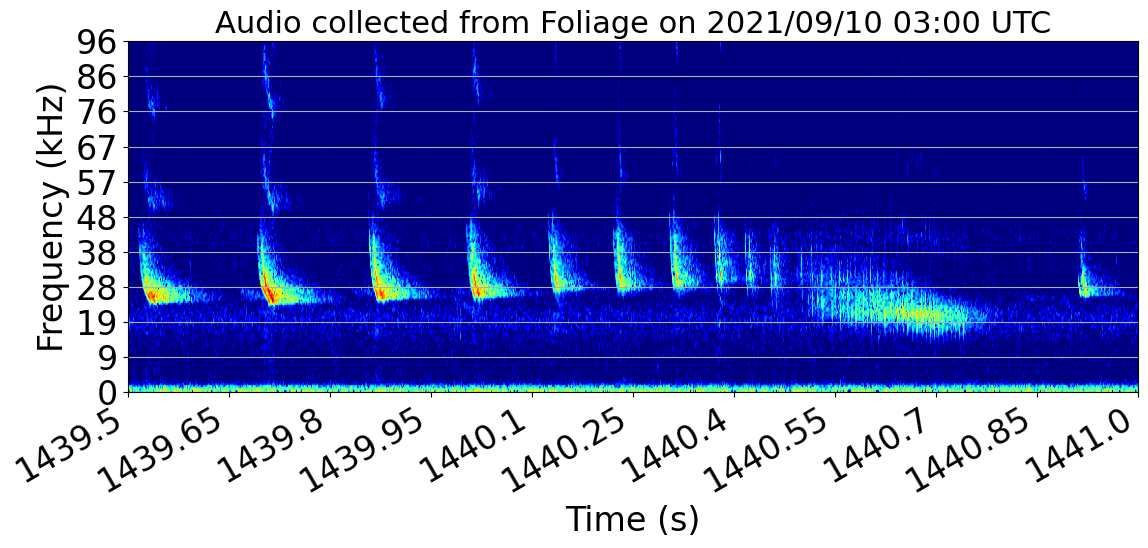

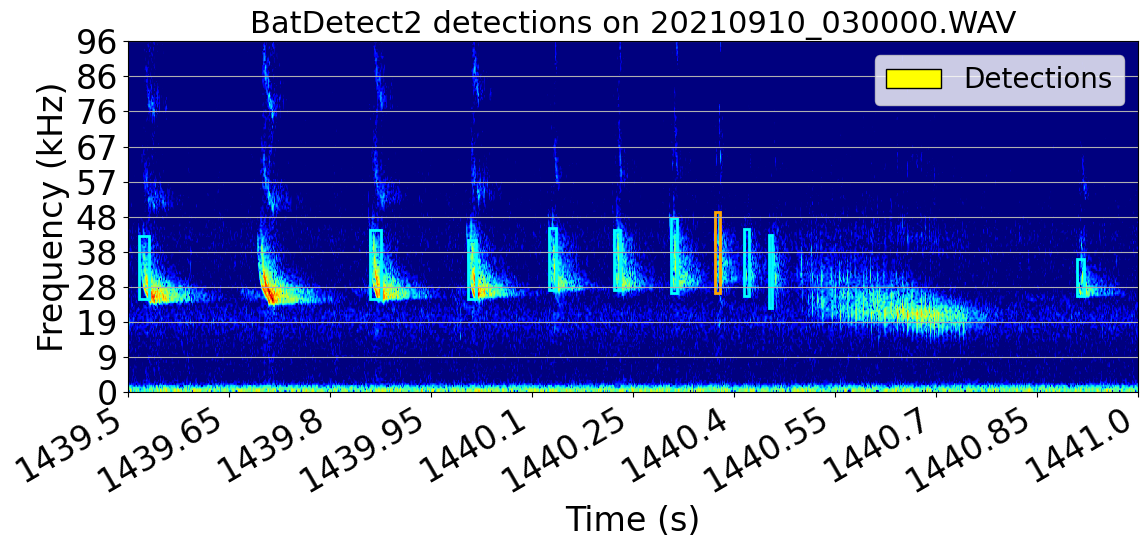

In [15]:
site_key = 'Foliage'

fig_details = dict()
fig_details['site_name'] = SITE_NAMES[site_key]
print(f'Looking at {fig_details["site_name"]}')
files_from_loc = sorted(list(Path(f'../data/audiomoth_recordings/').glob(pattern=f'*/{site_key}/*.WAV')))

file_path = files_from_loc[0]
filename = file_path.name
csv_path = Path(f'../batdetect2_outputs/recover-20210912/{site_key}/bd2_{filename.split(".")[0]}.csv')
print(f'Looking at {file_path.name}')
start = 1439.5
duration = 1.5
rm_dB = 45
nfft = 512

load_and_plot_file(file_path, csv_path, start, duration, rm_dB, nfft)

In [16]:
site_key = file_path.parent.name

data_params = dict()
data_params['site_tag'] = site_key
data_params['type_tag'] = ''
data_params['cur_dc_tag'] = '1800of1800'
batdetect2_predictions_no_dutycycle = actvt.assemble_single_bd2_output(csv_path, data_params)
plot_dets_no_dutycycle = batdetect2_predictions_no_dutycycle.loc[np.logical_and(batdetect2_predictions_no_dutycycle['start_time'] > start, batdetect2_predictions_no_dutycycle['end_time'] < (start+duration))]
plot_dets_no_dutycycle

freq_group                      ref_time               call_start_time  \
1947        LF1 2021-09-10 03:23:59.516499999 2021-09-10 03:23:59.516499999   
1948        LF1 2021-09-10 03:23:59.859500000 2021-09-10 03:23:59.859500000   
1949        LF1 2021-09-10 03:24:00.004500000 2021-09-10 03:24:00.004500000   
1950        LF1 2021-09-10 03:24:00.125500000 2021-09-10 03:24:00.125500000   
1951        LF1 2021-09-10 03:24:00.221500000 2021-09-10 03:24:00.221500000   
1952        LF1 2021-09-10 03:24:00.306500000 2021-09-10 03:24:00.306500000   
1953        LF1 2021-09-10 03:24:00.371500000 2021-09-10 03:24:00.371500000   
1954        LF1 2021-09-10 03:24:00.415500000 2021-09-10 03:24:00.415500000   
1955        LF1 2021-09-10 03:24:00.452500000 2021-09-10 03:24:00.452500000   
1956        LF1 2021-09-10 03:24:00.909500000 2021-09-10 03:24:00.909500000   

                  call_end_time  start_time   end_time  low_freq  high_freq  \
1947 2021-09-10 03:23:59.532000   1439.5165  1439.5320   25468.0    42833.0   
1948 2021-09-10 03:23:59.876100   1439.8595  1439.8761   25468.0    44298.0   
1949 2021-09-10 03:24:00.017000   1440.0045  1440.0170   25468.0    41701.0   
1950 2021-09-10 03:24:00.136100   1440.1255  1440.1361   28046.0    44833.0   
1951 2021-09-10 03:24:00.231600   1440.2215  1440.2316   28046.0    44488.0   
1952 2021-09-10 03:24:00.316000   1440.3065  1440.3160   27187.0    47623.0   
1953 2021-09-10 03:24:00.379000   1440.3715  1440.3790   27187.0    49199.0   
1954 2021-09-10 03:24:00.422200   1440.4155  1440.4222   26328.0    44662.0   
1955 2021-09-10 03:24:00.457300   1440.4525  1440.4573   22890.0    42895.0   
1956 2021-09-10 03:24:00.920300   1440.9095  1440.9203   26328.0    36463.0   

             event                class  class_prob  det_prob  individual  \
1947  Echolocation  Eptesicus serotinus       0.380     0.519          -1   
1948  Echolocation  Eptesicus serotinus       0.388     0.548          -1   
1949  Echolocation  Eptesicus serotinus       0.441     0.570          -1   
1950  Echolocation  Eptesicus serotinus       0.326     0.530          -1   
1951  Echolocation    Nyctalus leisleri       0.312     0.594          -1   
1952  Echolocation  Eptesicus serotinus       0.298     0.565          -1   
1953  Echolocation  Eptesicus serotinus       0.302     0.530          -1   
1954  Echolocation  Eptesicus serotinus       0.325     0.553          -1   
1955  Echolocation  Plecotus austriacus       0.322     0.518          -1   
1956  Echolocation    Nyctalus leisleri       0.389     0.626          -1   

                                             input_file  \
1947  /Users/adityakrishna/Documents/Research/Lab_re...   
1948  /Users/adityakrishna/Documents/Research/Lab_re...   
1949  /Users/adityakrishna/Documents/Research/Lab_re...   
1950  /Users/adityakrishna/Documents/Research/Lab_re...   
1951  /Users/adityakrishna/Documents/Research/Lab_re...   
1952  /Users/adityakrishna/Documents/Research/Lab_re...   
1953  /Users/adityakrishna/Documents/Research/Lab_re...   
1954  /Users/adityakrishna/Documents/Research/Lab_re...   
1955  /Users/adityakrishna/Documents/Research/Lab_re...   
1956  /Users/adityakrishna/Documents/Research/Lab_re...   

              Recover Folder   SD Card Site name  
1947  recover-20210912_unit2  UBNA_002   Foliage  
1948  recover-20210912_unit2  UBNA_002   Foliage  
1949  recover-20210912_unit2  UBNA_002   Foliage  
1950  recover-20210912_unit2  UBNA_002   Foliage  
1951  recover-20210912_unit2  UBNA_002   Foliage  
1952  recover-20210912_unit2  UBNA_002   Foliage  
1953  recover-20210912_unit2  UBNA_002   Foliage  
1954  recover-20210912_unit2  UBNA_002   Foliage  
1955  recover-20210912_unit2  UBNA_002   Foliage  
1956  recover-20210912_unit2  UBNA_002   Foliage

In [17]:
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
call_signals, dets = open_and_get_call_info(audio_file, plot_dets_no_dutycycle.copy())
dets

KMEANS_CLASSES  peak_frequency        SNR freq_group  \
0             LF         26880.0  33.426069        LF1   
1             LF         26880.0  35.098988        LF1   
2             LF         27840.0  34.697902        LF1   
3             LF         30720.0  31.692757        LF1   
4             LF         31680.0  32.944489        LF1   
5             LF         31680.0  31.159232        LF1   
6             HF         31680.0  23.218547        LF1   
7             LF         31680.0  11.310738        LF1   
8             LF         31680.0  11.033098        LF1   
9             LF         27840.0  26.903343        LF1   

                       ref_time               call_start_time  \
0 2021-09-10 03:23:59.516499999 2021-09-10 03:23:59.516499999   
1 2021-09-10 03:23:59.859500000 2021-09-10 03:23:59.859500000   
2 2021-09-10 03:24:00.004500000 2021-09-10 03:24:00.004500000   
3 2021-09-10 03:24:00.125500000 2021-09-10 03:24:00.125500000   
4 2021-09-10 03:24:00.221500000 2021-09-10 03:24:00.221500000   
5 2021-09-10 03:24:00.306500000 2021-09-10 03:24:00.306500000   
6 2021-09-10 03:24:00.371500000 2021-09-10 03:24:00.371500000   
7 2021-09-10 03:24:00.415500000 2021-09-10 03:24:00.415500000   
8 2021-09-10 03:24:00.452500000 2021-09-10 03:24:00.452500000   
9 2021-09-10 03:24:00.909500000 2021-09-10 03:24:00.909500000   

               call_end_time  start_time   end_time  low_freq  ...  \
0 2021-09-10 03:23:59.532000   1439.5165  1439.5320   25468.0  ...   
1 2021-09-10 03:23:59.876100   1439.8595  1439.8761   25468.0  ...   
2 2021-09-10 03:24:00.017000   1440.0045  1440.0170   25468.0  ...   
3 2021-09-10 03:24:00.136100   1440.1255  1440.1361   28046.0  ...   
4 2021-09-10 03:24:00.231600   1440.2215  1440.2316   28046.0  ...   
5 2021-09-10 03:24:00.316000   1440.3065  1440.3160   27187.0  ...   
6 2021-09-10 03:24:00.379000   1440.3715  1440.3790   27187.0  ...   
7 2021-09-10 03:24:00.422200   1440.4155  1440.4222   26328.0  ...   
8 2021-09-10 03:24:00.457300   1440.4525  1440.4573   22890.0  ...   
9 2021-09-10 03:24:00.920300   1440.9095  1440.9203   26328.0  ...   

   class_prob det_prob individual  \
0       0.380    0.519         -1   
1       0.388    0.548         -1   
2       0.441    0.570         -1   
3       0.326    0.530         -1   
4       0.312    0.594         -1   
5       0.298    0.565         -1   
6       0.302    0.530         -1   
7       0.325    0.553         -1   
8       0.322    0.518         -1   
9       0.389    0.626         -1   

                                          input_file          Recover Folder  \
0  /Users/adityakrishna/Documents/Research/Lab_re...  recover-20210912_unit2   
1  /Users/adityakrishna/Documents/Research/Lab_re...  recover-20210912_unit2   
2  /Users/adityakrishna/Documents/Research/Lab_re...  recover-20210912_unit2   
3  /Users/adityakrishna/Documents/Research/Lab_re...  recover-20210912_unit2   
4  /Users/adityakrishna/Documents/Research/Lab_re...  recover-20210912_unit2   
5  /Users/adityakrishna/Documents/Research/Lab_re...  recover-20210912_unit2   
6  /Users/adityakrishna/Documents/Research/Lab_re...  recover-20210912_unit2   
7  /Users/adityakrishna/Documents/Research/Lab_re...  recover-20210912_unit2   
8  /Users/adityakrishna/Documents/Research/Lab_re...  recover-20210912_unit2   
9  /Users/adityakrishna/Documents/Research/Lab_re...  recover-20210912_unit2   

    SD Card Site name index            file_name sampling_rate  
0  UBNA_002   Foliage     0  20210910_030000.WAV        250000  
1  UBNA_002   Foliage     1  20210910_030000.WAV        250000  
2  UBNA_002   Foliage     2  20210910_030000.WAV        250000  
3  UBNA_002   Foliage     3  20210910_030000.WAV        250000  
4  UBNA_002   Foliage     4  20210910_030000.WAV        250000  
5  UBNA_002   Foliage     5  20210910_030000.WAV        250000  
6  UBNA_002   Foliage     6  20210910_030000.WAV        250000  
7  UBNA_002   Foliage     7  20210910_030000.WAV        250000  
8 

Looking at Carp Pond
Looking at 20221004_030000.WAV


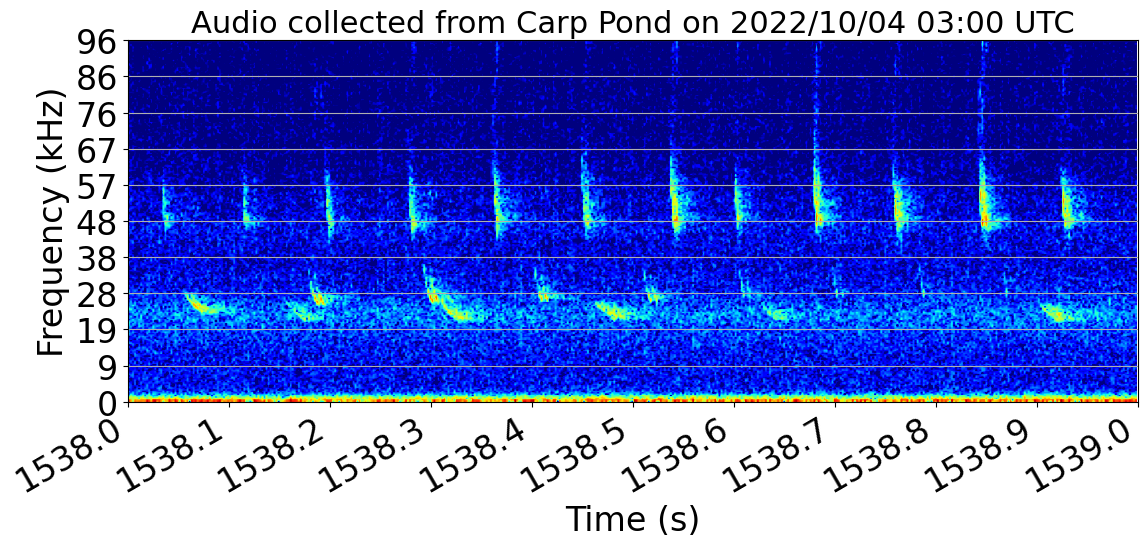

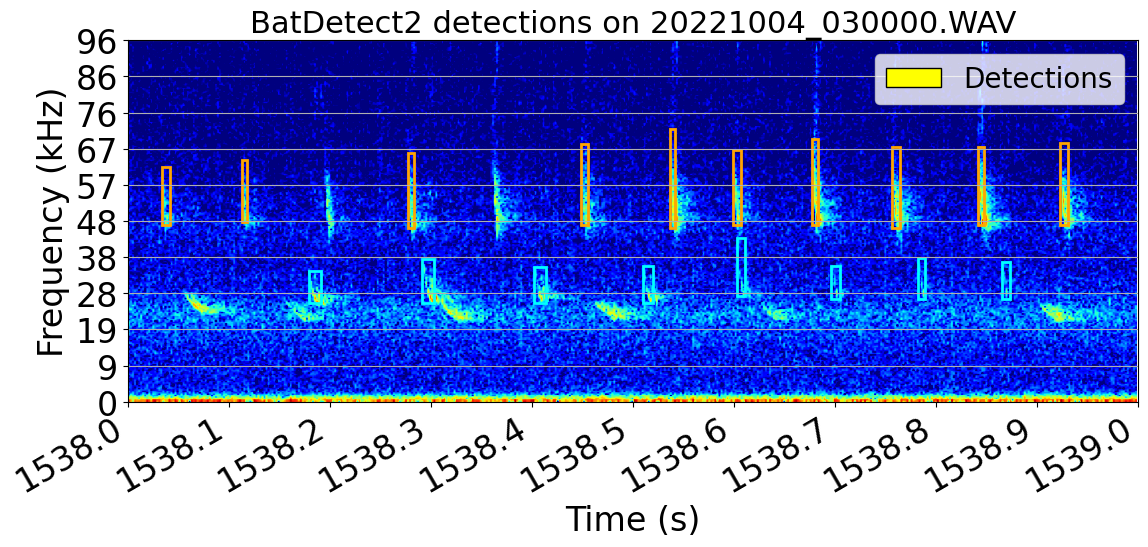

In [18]:
site_key = 'Carp'

fig_details = dict()
fig_details['site_name'] = SITE_NAMES[site_key]
print(f'Looking at {fig_details["site_name"]}')
files_from_loc = sorted(list(Path(f'../data/audiomoth_recordings/').glob(pattern=f'*/{site_key}/*.WAV')))

file_path = files_from_loc[21]
filename = file_path.name
csv_path = Path(f'../data/raw/{site_key}/bd2__{site_key}_{filename.split(".")[0]}.csv')
print(f'Looking at {file_path.name}')
start = 1538
duration = 1
rm_dB = 40
nfft = 512

load_and_plot_file(file_path, csv_path, start, duration, rm_dB, nfft)

In [19]:
site_key = file_path.parent.name

data_params = dict()
data_params['site_tag'] = site_key
data_params['type_tag'] = ''
data_params['cur_dc_tag'] = '1800of1800'
batdetect2_predictions_no_dutycycle = actvt.assemble_single_bd2_output(csv_path, data_params)
plot_dets_no_dutycycle = batdetect2_predictions_no_dutycycle.loc[np.logical_and(batdetect2_predictions_no_dutycycle['start_time'] > start, batdetect2_predictions_no_dutycycle['end_time'] < (start+duration))]
plot_dets_no_dutycycle

freq_group                      ref_time               call_start_time  \
1463        HF2 2022-10-04 03:25:38.033500000 2022-10-04 03:25:38.033500000   
1464        HF2 2022-10-04 03:25:38.113500000 2022-10-04 03:25:38.113500000   
1465        LF1 2022-10-04 03:25:38.179500000 2022-10-04 03:25:38.179500000   
1466        HF2 2022-10-04 03:25:38.277500000 2022-10-04 03:25:38.277500000   
1467        LF1 2022-10-04 03:25:38.291500000 2022-10-04 03:25:38.291500000   
1468        LF1 2022-10-04 03:25:38.402500000 2022-10-04 03:25:38.402500000   
1469        HF2 2022-10-04 03:25:38.448500000 2022-10-04 03:25:38.448500000   
1470        LF1 2022-10-04 03:25:38.510499999 2022-10-04 03:25:38.510499999   
1471        HF2 2022-10-04 03:25:38.536500000 2022-10-04 03:25:38.536500000   
1472        HF2 2022-10-04 03:25:38.599500000 2022-10-04 03:25:38.599500000   
1473        LF1 2022-10-04 03:25:38.603500000 2022-10-04 03:25:38.603500000   
1474        HF2 2022-10-04 03:25:38.677500000 2022-10-04 03:25:38.677500000   
1475        LF1 2022-10-04 03:25:38.696500000 2022-10-04 03:25:38.696500000   
1476        HF2 2022-10-04 03:25:38.756500000 2022-10-04 03:25:38.756500000   
1477        LF1 2022-10-04 03:25:38.782500000 2022-10-04 03:25:38.782500000   
1478        HF2 2022-10-04 03:25:38.841500000 2022-10-04 03:25:38.841500000   
1479        LF1 2022-10-04 03:25:38.865500000 2022-10-04 03:25:38.865500000   
1480        HF2 2022-10-04 03:25:38.922500000 2022-10-04 03:25:38.922500000   

                  call_end_time  start_time   end_time  low_freq  high_freq  \
1463 2022-10-04 03:25:38.041600   1538.0335  1538.0416   46953.0    62462.0   
1464 2022-10-04 03:25:38.118500   1538.1135  1538.1185   47812.0    64134.0   
1465 2022-10-04 03:25:38.191200   1538.1795  1538.1912   26328.0    34628.0   
1466 2022-10-04 03:25:38.283800   1538.2775  1538.2838   46093.0    66157.0   
1467 2022-10-04 03:25:38.303000   1538.2915  1538.3030   26328.0    38029.0   
1468 2022-10-04 03:25:38.413600   1538.4025  1538.4136   26328.0    35816.0   
1469 2022-10-04 03:25:38.455900   1538.4485  1538.4559   46953.0    68471.0   
1470 2022-10-04 03:25:38.520200   1538.5105  1538.5202   26328.0    36022.0   
1471 2022-10-04 03:25:38.542200   1538.5365  1538.5422   46093.0    72439.0   
1472 2022-10-04 03:25:38.606900   1538.5995  1538.6069   46953.0    66852.0   
1473 2022-10-04 03:25:38.611300   1538.6035  1538.6113   28046.0    43548.0   
1474 2022-10-04 03:25:38.683700   1538.6775  1538.6837   46953.0    69895.0   
1475 2022-10-04 03:25:38.705400   1538.6965  1538.7054   27187.0    36089.0   
1476 2022-10-04 03:25:38.764200   1538.7565  1538.7642   46093.0    67713.0   
1477 2022-10-04 03:25:38.789500   1538.7825  1538.7895   27187.0    38167.0   
1478 2022-10-04 03:25:38.847900   1538.8415  1538.8479   46953.0    67773.0   
1479 2022-10-04 03:25:38.873400   1538.8655  1538.8734   27187.0    37123.0   
1480 2022-10-04 03:25:38.930900   1538.9225  1538.9309   46953.0    68714.0   

                          class  class_prob  det_prob  individual  \
1463  Pipistrellus pipistrellus       0.590     0.626          -1   
1464  Pipistrellus pipistrellus       0.637     0.656          -1   
1465        Eptesicus serotinus       0.335     0.615          -1   
1466  Pipistrellus pipistrellus       0.581     0.650          -1   
1467        Eptesicus serotinus       0.513     0.661          -1   
1468        Eptesicus serotinus       0.458     0.602          -1   
1469  Pipistrellus pipistrellus       0.495     0.593          -1   
1470        Eptesicus serotinus       0.465     0.629          -1   
1471  Pipistrellus pipistrellus       0.552     0.583          -1   
1472  Pipistrellus pipistrellus       0.578     0.638          -1   
1473          Nyctalus leisleri       0.273     0.576          -1   
1474  Pipistrellus pipistrellus       0.567     0.645          -1   
1475        Eptesicus serotinus       0.415     0.570          -1   
1476  Pipistrellus pipistrellus    

In [20]:
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
call_signals, dets = open_and_get_call_info(audio_file, plot_dets_no_dutycycle.copy())
dets

KMEANS_CLASSES  peak_frequency        SNR freq_group  \
0              HF         48960.0  10.939312        HF2   
1              HF         48000.0  12.886352        HF2   
2              LF         26880.0  15.671595        LF1   
3              HF         48960.0  16.028560        HF2   
4              LF         27840.0  19.042314        LF1   
5              LF         27840.0  15.306078        LF1   
6              HF         48000.0  17.429185        HF2   
7              LF         27840.0  11.597109        LF1   
8              HF         48960.0  24.183803        HF2   
9              HF         48960.0  16.402316        HF2   
10             LF         28800.0   6.715575        LF1   
11             HF         48960.0  24.416050        HF2   
12             LF         28800.0   5.341645        LF1   
13             HF         49920.0  22.232023        HF2   
14             LF         28800.0   5.261856        LF1   
15             HF         48000.0  26.328584        HF2   
16             LF         29760.0   1.452651        LF1   
17             HF         50880.0  22.747317        HF2   

                        ref_time               call_start_time  \
0  2022-10-04 03:25:38.033500000 2022-10-04 03:25:38.033500000   
1  2022-10-04 03:25:38.113500000 2022-10-04 03:25:38.113500000   
2  2022-10-04 03:25:38.179500000 2022-10-04 03:25:38.179500000   
3  2022-10-04 03:25:38.277500000 2022-10-04 03:25:38.277500000   
4  2022-10-04 03:25:38.291500000 2022-10-04 03:25:38.291500000   
5  2022-10-04 03:25:38.402500000 2022-10-04 03:25:38.402500000   
6  2022-10-04 03:25:38.448500000 2022-10-04 03:25:38.448500000   
7  2022-10-04 03:25:38.510499999 2022-10-04 03:25:38.510499999   
8  2022-10-04 03:25:38.536500000 2022-10-04 03:25:38.536500000   
9  2022-10-04 03:25:38.599500000 2022-10-04 03:25:38.599500000   
10 2022-10-04 03:25:38.603500000 2022-10-04 03:25:38.603500000   
11 2022-10-04 03:25:38.677500000 2022-10-04 03:25:38.677500000   
12 2022-10-04 03:25:38.696500000 2022-10-04 03:25:38.696500000   
13 2022-10-04 03:25:38.756500000 2022-10-04 03:25:38.756500000   
14 2022-10-04 03:25:38.782500000 2022-10-04 03:25:38.782500000   
15 2022-10-04 03:25:38.841500000 2022-10-04 03:25:38.841500000   
16 2022-10-04 03:25:38.865500000 2022-10-04 03:25:38.865500000   
17 2022-10-04 03:25:38.922500000 2022-10-04 03:25:38.922500000   

                call_end_time  start_time   end_time  low_freq  ...  det_prob  \
0  2022-10-04 03:25:38.041600   1538.0335  1538.0416   46953.0  ...     0.626   
1  2022-10-04 03:25:38.118500   1538.1135  1538.1185   47812.0  ...     0.656   
2  2022-10-04 03:25:38.191200   1538.1795  1538.1912   26328.0  ...     0.615   
3  2022-10-04 03:25:38.283800   1538.2775  1538.2838   46093.0  ...     0.650   
4  2022-10-04 03:25:38.303000   1538.2915  1538.3030   26328.0  ...     0.661   
5  2022-10-04 03:25:38.413600   1538.4025  1538.4136   26328.0  ...     0.602   
6  2022-10-04 03:25:38.455900   1538.4485  1538.4559   46953.0  ...     0.593   
7  2022-10-04 03:25:38.520200   1538.5105  1538.5202   26328.0  ...     0.629   
8  2022-10-04 03:25:38.542200   1538.5365  1538.5422   46093.0  ...     0.583   
9  2022-10-04 03:25:38.606900   1538.5995  1538.6069   46953.0  ...     0.638   
10 2022-10-04 03:25:38.611300   1538.6035  1538.6113   28046.0  ...     0.576   
11 2022-10-04 03:25:38.683700   1538.6775  1538.6837   46953.0  ...     0.645   
12 2022-10-04 03:25:38.705400   1538.6965  1538.7054   27187.0  ...     0.570   
13 2022-10-04 03:25:38.764200   1538.7565  1538.7642   46093.0  ...     0.675   
14 2022-10-04 03:25:38.789500   1538.7825  1538.7895   27187.0  ...     0.665   
15 2022-10-04 03:25:38.847900   1538.8415  1538.8479   46953.0  ...     0.634   
16 2022-10-04 03:25:38.873400   1538.8655  1538.8734   27187.0  ...     0.546   
17 2022-10-04 03:25:38.930900   1538.9225  1538.9309   46953.0  ...     0.698   

   individual         event  \
0          -1  Echolocation   
1          -1  Echolocat